# Modeling par régression

Objectif : entraîner et comparer plusieurs modèles de régression (linéaire, ridge, lasso, forêts aléatoires, gradient boosting) sur le jeu nettoyé.

Plan rapide :
- Charger les jeux `train_reg.csv` / `test_reg.csv` issus du notebook 03.
- Définir les tâches de régression (math, reading, writing, exam).
- Préparer les splits train/val/test et le préprocesseur (one-hot).
- Entraîner, comparer, sélectionner le meilleur modèle par tâche.
- Réentraîner sur train+val, évaluer sur test, sauvegarder et illustrer une inférence.


In [1]:
# Imports principaux et constantes
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import OrderedDict

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.base import clone
import joblib

sns.set_style('whitegrid')
RANDOM_STATE = 42


In [2]:
# Charger les jeux nettoyés préparés dans 03_Nettoyage
train_path = Path('..') / 'data' / 'processed' / 'train_reg.csv'
test_path = Path('..') / 'data' / 'processed' / 'test_reg.csv'

for p in [train_path, test_path]:
    assert p.exists(), f"Fichier manquant : {p}"

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

# Variables socio-démo utilisées comme features
base_cols = [
    'gender',
    'race_ethnicity',
    'parental_level_of_education',
    'lunch',
    'test_preparation_course',
]

train_df.head()


,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score,language_score,exam_score
0,0,5,4,0,1,0.79,0.74,0.72,0.73,0.76
1,1,3,0,0,1,0.59,0.71,0.65,0.68,0.64
2,0,4,2,1,0,0.79,0.73,0.67,0.70,0.74
3,0,0,2,0,0,0.75,0.81,0.74,0.78,0.76
4,1,4,2,1,1,0.75,0.77,0.83,0.80,0.78


In [3]:
# Tâches de régression : cible continue + features socio-démo

tasks = OrderedDict({
    'math': {
        'target': 'math_score',
        'features': base_cols,
    },
    'reading': {
        'target': 'reading_score',
        'features': base_cols,
    },
    'writing': {
        'target': 'writing_score',
        'features': base_cols,
    },
    'exam': {
        'target': 'exam_score',
        'features': base_cols,
    },
})

tasks


OrderedDict([('math',
              {'target': 'math_score',
               'features': ['gender',
                'race_ethnicity',
                'parental_level_of_education',
                'lunch',
                'test_preparation_course']}),
             ('reading',
              {'target': 'reading_score',
               'features': ['gender',
                'race_ethnicity',
                'parental_level_of_education',
                'lunch',
                'test_preparation_course']}),
             ('writing',
              {'target': 'writing_score',
               'features': ['gender',
                'race_ethnicity',
                'parental_level_of_education',
                'lunch',
                'test_preparation_course']}),
             ('exam',
              {'target': 'exam_score',
               'features': ['gender',
                'race_ethnicity',
                'parental_level_of_education',
                'lunch',
                'test_preparat

In [4]:
# Splits train/val et test holdout par tâche

data_splits = OrderedDict()

for task_name, spec in tasks.items():
    feat_cols = spec['features']
    target = spec['target']

    X_full = train_df[feat_cols]
    y_full = train_df[target]

    X_test = test_df[feat_cols]
    y_test = test_df[target]

    # Split train/val à 80/20
    X_train, X_val, y_train, y_val = train_test_split(
        X_full, y_full, test_size=0.2, random_state=RANDOM_STATE
    )

    data_splits[task_name] = {
        'X_train': X_train,
        'X_val': X_val,
        'y_train': y_train,
        'y_val': y_val,
        'X_test': X_test,
        'y_test': y_test,
        'categorical_cols': feat_cols,
        'numeric_cols': [],
    }

    print(f"Tâche: {task_name} -> Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")


Tâche: math -> Train: (640, 5), Val: (160, 5), Test: (200, 5)
Tâche: reading -> Train: (640, 5), Val: (160, 5), Test: (200, 5)
Tâche: writing -> Train: (640, 5), Val: (160, 5), Test: (200, 5)
Tâche: exam -> Train: (640, 5), Val: (160, 5), Test: (200, 5)


In [5]:
# Préprocesseur : one-hot sur les catégorielles (pas de numériques dans ce jeu)

def make_preprocessor(categorical_cols, numeric_cols):
    transformers = []
    if categorical_cols:
        transformers.append(('categorical', OneHotEncoder(handle_unknown='ignore'), categorical_cols))
    if numeric_cols:
        transformers.append(('numeric', Pipeline([('scaler', StandardScaler())]), numeric_cols))
    return ColumnTransformer(transformers=transformers, remainder='drop')

preprocessor_example = make_preprocessor(base_cols, [])
preprocessor_example


,transformers,"[('categorical', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,categories,'auto'
,drop,None
,sparse_output,True


### Choix des modèles

On compare cinq familles complémentaires :
- Régression linéaire : baseline sans régularisation.
- Ridge : pénalisation L2 pour limiter la variance.
- Lasso : pénalisation L1 pour encourager la sparsité des coefficients.
- Random Forest Regressor : ensemble d’arbres pour capturer les non-linéarités.
- Gradient Boosting Regressor : boosting d’arbres faibles, souvent performant sur petits jeux tabulaires.


In [6]:
# Catalogue de modèles à tester
models = {
    'linear': LinearRegression(),
    'ridge': Ridge(alpha=1.0, random_state=RANDOM_STATE),
    'lasso': Lasso(alpha=0.001, max_iter=10000, random_state=RANDOM_STATE),
    'rf': RandomForestRegressor(
        n_estimators=400,
        max_depth=None,
        random_state=RANDOM_STATE,
        n_jobs=-1,
    ),
    'gboost': GradientBoostingRegressor(random_state=RANDOM_STATE),
}
models


{'linear': LinearRegression(),
 'ridge': Ridge(random_state=42),
 'lasso': Lasso(alpha=0.001, max_iter=10000, random_state=42),
 'rf': RandomForestRegressor(n_estimators=400, n_jobs=-1, random_state=42),
 'gboost': GradientBoostingRegressor(random_state=42)}

### Lecture des résultats validation

- `rmse` et `mae` bas : erreurs faibles (meilleur).
- `r2` proche de 1 : bonne explication de la variance.
Le meilleur modèle par tâche est choisi sur le plus faible `rmse`.


In [7]:
# Entraînement + évaluation validation pour chaque tâche et chaque modèle

def fit_eval(model, X_tr, y_tr, X_va, y_va, categorical_cols, numeric_cols):
    preprocess = make_preprocessor(categorical_cols, numeric_cols)
    pipe = Pipeline([('preprocess', preprocess), ('model', model)])
    pipe.fit(X_tr, y_tr)
    preds = pipe.predict(X_va)
    mae = mean_absolute_error(y_va, preds)
    rmse = root_mean_squared_error(y_va, preds)
    r2 = r2_score(y_va, preds)
    return {
        'mae': mae,
        'rmse': rmse,
        'r2': r2,
        'pipeline': pipe,
    }

results = []
best_by_task = {}
all_pipelines = {}

for task_name, split in data_splits.items():
    all_pipelines[task_name] = {}
    for name, model in models.items():
        res = fit_eval(
            clone(model),
            split['X_train'], split['y_train'],
            split['X_val'], split['y_val'],
            split['categorical_cols'], split['numeric_cols'],
        )
        results.append({
            'target_task': task_name,
            'model': name,
            'mae': res['mae'],
            'rmse': res['rmse'],
            'r2': res['r2'],
        })
        all_pipelines[task_name][name] = res['pipeline']

    # Sélection du meilleur RMSE pour la tâche
    best_name = min(
        all_pipelines[task_name].keys(),
        key=lambda m: next(r['rmse'] for r in results if r['target_task']==task_name and r['model']==m)
    )
    best_row = [r for r in results if r['target_task']==task_name and r['model']==best_name][0]
    best_by_task[task_name] = {
        'model_name': best_name,
        'rmse': best_row['rmse'],
        'mae': best_row['mae'],
        'r2': best_row['r2'],
        'pipeline': all_pipelines[task_name][best_name],
    }

# Tableau récap des scores validation

df_res = pd.DataFrame(results).sort_values(['target_task', 'rmse']).reset_index(drop=True)
df_res


,target_task,model,mae,rmse,r2
0,exam,linear,0.095252,0.115722,0.302015
1,exam,ridge,0.095310,0.115785,0.301254
2,exam,lasso,0.096505,0.117315,0.282661
3,exam,gboost,0.098084,0.119646,0.253878
4,exam,rf,0.106280,0.129302,0.128574
5,math,linear,0.102467,0.124162,0.283984
6,math,ridge,0.102502,0.124188,0.283688
7,math,lasso,0.103273,0.124978,0.274541
8,math,gboost,0.103905,0.129364,0.222727
9,math,rf,0.112375,0.137523,0.121596


### Visualisation des scores validation

Le graphique suivant permet de comparer visuellement les métriques par tâche et par modèle. Priorité : `rmse` (plus petit) puis `mae`, contrôle avec `r2`.


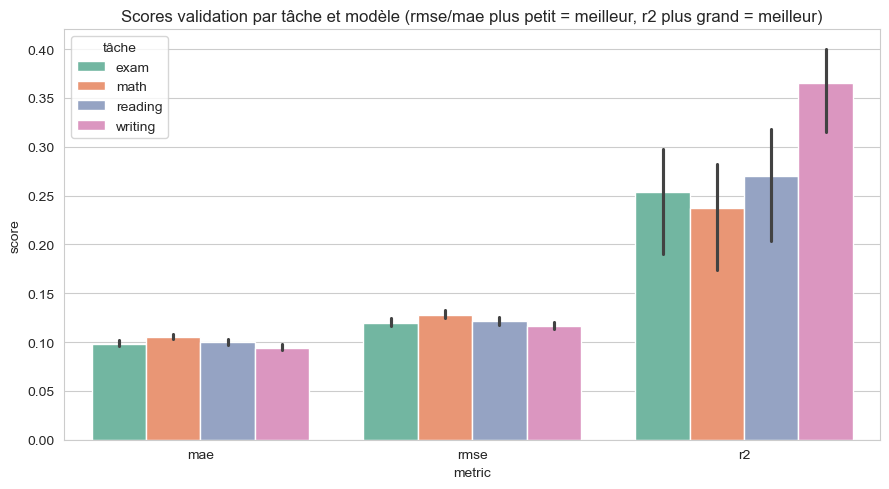

In [8]:
# Visualisation des métriques validation
plot_df = df_res.melt(id_vars=['target_task', 'model'], value_vars=['mae', 'rmse', 'r2'], var_name='metric', value_name='score')
plt.figure(figsize=(9, 5))
sns.barplot(data=plot_df, x='metric', y='score', hue='target_task', palette='Set2')
plt.title('Scores validation par tâche et modèle (rmse/mae plus petit = meilleur, r2 plus grand = meilleur)')
plt.legend(title='tâche')
plt.tight_layout()
plt.show()


### Sauvegarde des meilleurs modèles

Chaque tâche est réentraînée sur train+val pour profiter de plus de données, puis sauvegardée dans `models/` sous la forme `exam_regression_<tâche>_<modèle>.joblib`.


In [ ]:
# Ré-entraînement des meilleurs modèles sur train+val et sauvegarde
models_dir = Path('..') / 'models' / 'regression'
models_dir.mkdir(parents=True, exist_ok=True)
saved_models = []

for task_name, info in best_by_task.items():
    split = data_splits[task_name]
    # Refit sur plus de données (train+val)
    X_refit = pd.concat([split['X_train'], split['X_val']], axis=0)
    y_refit = pd.concat([split['y_train'], split['y_val']], axis=0)
    pipe = info['pipeline']
    pipe.fit(X_refit, y_refit)
    out_path = models_dir / f"exam_regression_{task_name}_{info['model_name']}.joblib"
    joblib.dump(pipe, out_path)
    saved_models.append({
        'task': task_name,
        'model': info['model_name'],
        'rmse': info['rmse'],
        'path': out_path,
    })

pd.DataFrame(saved_models)


,task,model,rmse,path
0,math,linear,0.124162,..\models\exam_regression_math_linear.joblib
1,reading,linear,0.116855,..\models\exam_regression_reading_linear.joblib
2,writing,linear,0.112806,..\models\exam_regression_writing_linear.joblib
3,exam,linear,0.115722,..\models\exam_regression_exam_linear.joblib


### Lecture des résultats test

Le tableau ci-dessous synthétise les métriques finales sur le jeu de test tenu à part. Vérifier cohérence avec la validation et absence de surapprentissage (écarts RMSE/MAE raisonnables).


In [10]:
# Évaluation finale sur le jeu de test tenu à part

test_results = []
test_preds_store = {}

for task_name, info in best_by_task.items():
    split = data_splits[task_name]
    pipe = info['pipeline']
    preds = pipe.predict(split['X_test'])
    mae = mean_absolute_error(split['y_test'], preds)
    rmse = root_mean_squared_error(split['y_test'], preds)
    r2 = r2_score(split['y_test'], preds)
    test_results.append({
        'target_task': task_name,
        'model': info['model_name'],
        'mae': mae,
        'rmse': rmse,
        'r2': r2,
    })
    test_preds_store[task_name] = {'y_true': split['y_test'], 'preds': preds}

# Tableau récap test

test_results_df = pd.DataFrame(test_results).sort_values('target_task')
test_results_df


,target_task,model,mae,rmse,r2
3,exam,linear,0.115902,0.137509,0.177236
0,math,linear,0.118284,0.141278,0.228261
1,reading,linear,0.120651,0.144873,0.137942
2,writing,linear,0.113136,0.135385,0.246873


### Exemple d'inférence

On illustre la prédiction de `exam_score` sur 5 profils tirés aléatoirement (train+test). Adapté pour démontrer l’usage du pipeline sauvegardé.


In [11]:
# Exemple d'inférence avec le meilleur modèle 'exam'

exam_pipe = best_by_task['exam']['pipeline']
# On prend un échantillon aléatoire de profils (train + test) pour illustrer la prédiction
full_df = pd.concat([train_df, test_df], axis=0, ignore_index=True)
sample_idx = full_df.sample(5, random_state=RANDOM_STATE).index
example = full_df.loc[sample_idx, base_cols + ['exam_score']].copy()
example['pred_exam_score'] = exam_pipe.predict(example[base_cols])
example

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,exam_score,pred_exam_score
521,0,3,3,1,1,0.74,0.740902
737,1,0,1,1,1,0.95,0.689243
740,1,3,0,0,0,0.64,0.543467
660,0,4,4,1,0,0.74,0.732616
411,1,5,0,1,0,0.79,0.689049
